In [33]:
import tensorflow as tf
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt
import numpy as np

In [2]:
image_size = 256
batch_size = 32
channels = 3
epochs = 20

In [3]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    'training',
    shuffle=True,
    image_size= (image_size,image_size),
    batch_size= batch_size
)

Found 2152 files belonging to 3 classes.


In [4]:
class_names = dataset.class_names
class_names

['Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy']

In [5]:
for image_batch, label_batch in dataset.take(1):
    print(image_batch.shape)
    print(label_batch.numpy())

(32, 256, 256, 3)
[1 0 0 1 1 2 1 0 1 0 0 0 1 0 1 2 1 2 0 0 1 0 1 1 0 0 0 1 0 1 0 0]


## Visualizing the images and labels

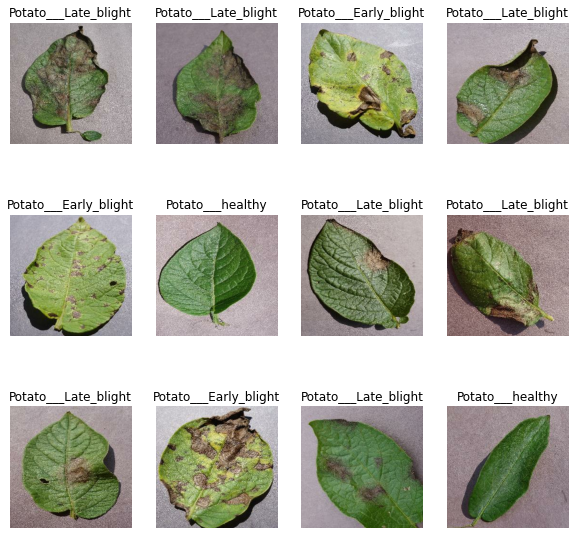

In [6]:
plt.figure(figsize = (10,10))
for image_batch, label_batch in dataset.take(1):
    for i in range(12):
        ax = plt.subplot(3,4,i+1)
        plt.title(class_names[label_batch[i]])
        plt.imshow(image_batch[i].numpy().astype('uint8'))
        plt.axis('off')

## Splitting the data into train and test

In [7]:
count = len(dataset)
print(count)
train_size = int(count*0.8)
train_size

68


54

In [8]:
def get_dataset_partition(ds, train_split = 0.8, val_split = 0.1, test_split=0.1, shuffle=True, shuffle_size = 10000):
    ds_size = len(ds)
    
    if shuffle:
        ds = ds.shuffle(shuffle_size, seed = 12)
    
    train_size = int(train_split*ds_size)
    val_size = int(val_split*ds_size)
    
    train_ds = ds.take(train_size)
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)
    
    return train_ds, val_ds, test_ds
    

In [9]:
train_ds, val_ds, test_ds = get_dataset_partition(dataset)

In [10]:
len(train_ds), len(val_ds), len(test_ds)

(54, 6, 8)

In [11]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

## Data Pre-proccesing: scaling and resizing the images

In [12]:
resize_and_resclae = tf.keras.Sequential([
    layers.experimental.preprocessing.Resizing(image_size,image_size),
    layers.experimental.preprocessing.Rescaling(1.0/255)
])

## Data Pre-proccesing: Data augmentation

In [13]:
data_augmentation = tf.keras.Sequential([
    layers.experimental.preprocessing.RandomFlip('horizontal_and_vertical'),
    layers.experimental.preprocessing.RandomRotation(0.2)
])

## Building the model

In [14]:
input_shape = (batch_size, image_size,image_size, channels)
model = models.Sequential([
    resize_and_resclae,
    data_augmentation,
    layers.Conv2D(32, (3,3),activation='relu', input_shape=input_shape ),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, kernel_size=(3,3),activation='relu' ),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, kernel_size= (3,3),activation='relu' ),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, kernel_size= (3,3),activation='relu' ),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, kernel_size= (3,3),activation='relu' ),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, kernel_size= (3,3),activation='relu' ),
    layers.MaxPooling2D((2,2)),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(3,activation='softmax')
])
model.build(input_shape=input_shape)

In [15]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (32, 256, 256, 3)         0         
                                                                 
 sequential_1 (Sequential)   (32, 256, 256, 3)         0         
                                                                 
 conv2d (Conv2D)             (32, 254, 254, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2D  (32, 127, 127, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (32, 125, 125, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (32, 62, 62, 64)         0         
 2D)                                                  

In [16]:
model.compile(
    optimizer='adam',
    loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics= ['accuracy']
)

In [17]:
history = model.fit(
    train_ds, 
    epochs=epochs,
    batch_size= batch_size,
    verbose=1,
    validation_data=val_ds
)

Epoch 1/20
54/54 [==============================] - 100s 2s/step - loss: 0.8924 - accuracy: 0.5191 - val_loss: 0.8055 - val_accuracy: 0.5990
Epoch 2/20
54/54 [==============================] - 121s 2s/step - loss: 0.7042 - accuracy: 0.6753 - val_loss: 0.5235 - val_accuracy: 0.7656
Epoch 3/20
54/54 [==============================] - 115s 2s/step - loss: 0.5228 - accuracy: 0.7824 - val_loss: 0.3426 - val_accuracy: 0.8750
Epoch 4/20
54/54 [==============================] - 82s 1s/step - loss: 0.3395 - accuracy: 0.8698 - val_loss: 0.2481 - val_accuracy: 0.9167
Epoch 5/20
54/54 [==============================] - 82s 2s/step - loss: 0.2664 - accuracy: 0.9034 - val_loss: 0.4340 - val_accuracy: 0.8281
Epoch 6/20
54/54 [==============================] - 80s 1s/step - loss: 0.3258 - accuracy: 0.8825 - val_loss: 0.2834 - val_accuracy: 0.8698
Epoch 7/20
54/54 [==============================] - 73s 1s/step - loss: 0.1994 - accuracy: 0.9334 - val_loss: 0.4439 - val_accuracy: 0.8333
Epoch 8/20
54/54 

In [18]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

Text(0.5, 1.0, 'Training and Validation Accuracy')

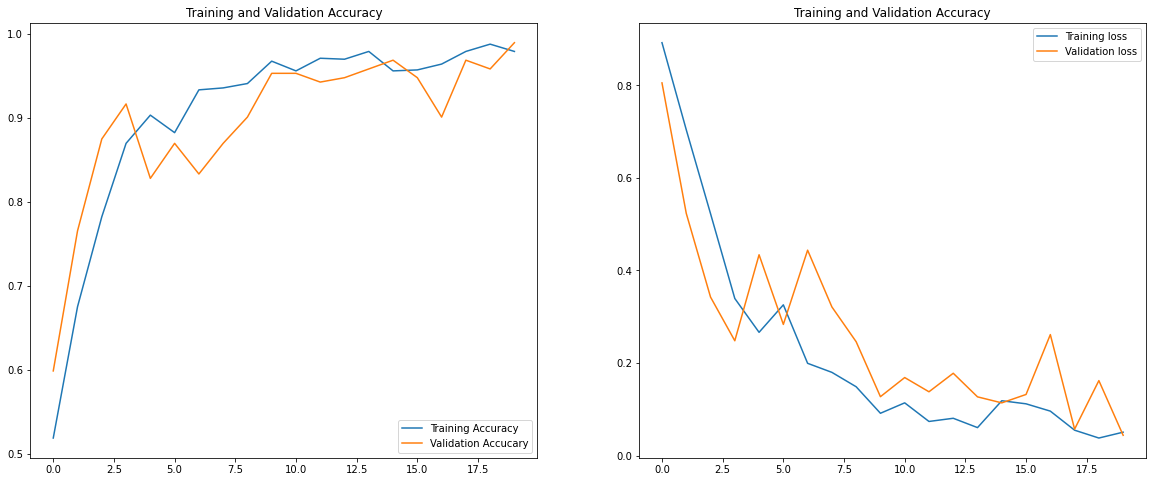

In [27]:
plt.figure(figsize = (20,8))
plt.subplot(1,2,1)
plt.plot(range(epochs), acc, label = 'Training Accuracy')
plt.plot(range(epochs),val_acc, label = 'Validation Accucary')
plt.legend(loc = 'lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1,2,2)
plt.plot(range(epochs), loss, label = 'Training loss')
plt.plot(range(epochs),val_loss, label = 'Validation loss')
plt.legend(loc = 'best')
plt.title('Training and Validation Accuracy')


first image to predict
actual label :  Potato___Late_blight
predicted label: Potato___Late_blight


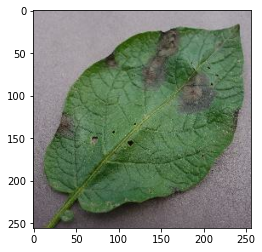

In [38]:
for images_batch, labels_batch in test_ds.take(1):
    first_image = images_batch[0].numpy().astype('uint8')
    first_label = labels_batch[0].numpy()
    
    print('first image to predict')
    plt.imshow(first_image)
    print('actual label : ', class_names[first_label])
    
    batch_prediction = model.predict(images_batch)
    print('predicted label:',class_names[np.argmax(batch_prediction[0])])

In [39]:
def predict(model,img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array,0)
    
    predictions = model.predict(img_array)
    predicted_class = class_names[np.argmax(batch_prediction[0])]
    confidence = round(100* (np.max(predictions[0])),2)
    return predicted_class, confidence

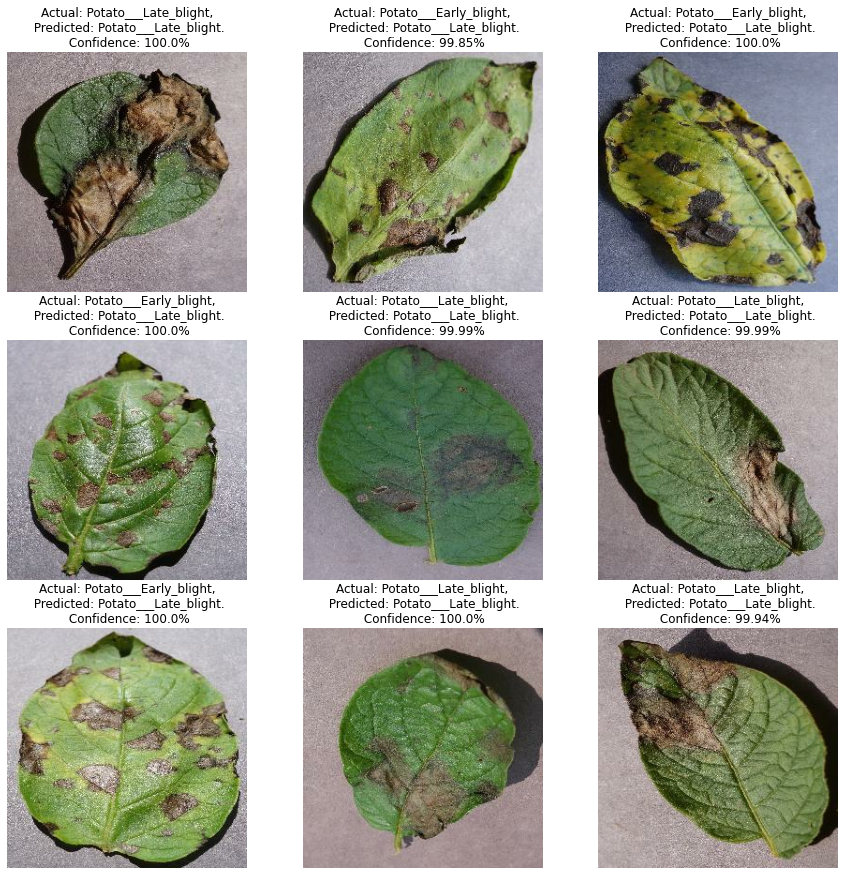

In [46]:
plt.figure(figsize=(15, 15))
for images, labels in test_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        
        predicted_class, confidence = predict(model, images[i].numpy())
        actual_class = class_names[labels[i]] 
        
        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}.\n Confidence: {confidence}%")
        
        plt.axis("off")

## Saving the model versions automatically

In [50]:
import os
model_version = max([int(i) for i in os.listdir("./models")+[0]])+1
model.save(f"./models/{model_version}")

INFO:tensorflow:Assets written to: ./models/2\assets
